# Tutorial: Non-parametric Density Estimation
## Introduction
In this tutorial we'll show how some of the estimators included in the **UNITE** toolbox can be used to estimate probability density using sample data *aka* non-parametric density estimation.

## The Data
First we'll generate samples of a specific probability distribution for which we want to calculate probability density at specific points $(x)$. In this tutorial we'll be using a mixture of two bivariate Gaussian distributions. Generally, a multivariate Gaussian distribution has the following probability density function (PDF):

$$
    p(X) = \frac{1}{\left ( 2\pi \right )^{d/2} \left ( \det{(\Sigma)} \right )^{1/2}} \exp{\left ( -\frac{1}{2}\left ( x - \mu \right )^\intercal \Sigma^{-1} \left ( x - \mu \right ) \right )}
$$

In this case $X$ would be 2D vector $(x_1, x_2)$. And the distribution would be parameterized by a 2D vector of means $\mu$ and a $2 \times 2$ covariance matrix $\Sigma$.

For this simple 2D case, the **UNITE** toolbox has auxiliary functions to generate samples through rejection sampling. We only need to define the PDF of the functions we want to sample and the ranges in which to sample.

Here we'll be a little bit more creative and sample a mixture of 2D Gaussian distributions. Let's do it:

In [1]:
import numpy as np
from scipy import stats
def pdf_bivariate_gaussian(x, y, params):
    z = 0.0
    for dist in params:
        l, s, w = dist
        z += stats.multivariate_normal(mean=l, cov=s).pdf(np.dstack((x, y))) * w
    return z
	
# Dist. parameters format: [[mu], [cov], weight]
dist_params = [
    [[-2, 0], [[1, -0.5], [-0.5, 1]], 0.5],  # 1st component
    [[2, 0], [[1, 0.5], [0.5, 1]], 0.5],  # 2nd component
]

dist_lims = [[-25, 25], [-25, 25]] # Lower and upper limits per dimension

Having properly defined our PDF, now we can generate $1\,000$ samples of this bivariate Gaussian mixture distribution using the **UNITE** toolbox.

In [2]:
from unite_toolbox.utils.sampling import get_samples
samples = get_samples(
    func = pdf_bivariate_gaussian,
    limits = dist_lims,
    n_samples = 1_000,
    seed = 42,
    params = dist_params,
)

That's it! Now we have $1\,000$ samples to test non-parametric density estimation methods. Before we proceed, let's plot the true distribution and check that the samples were corretly sampled.

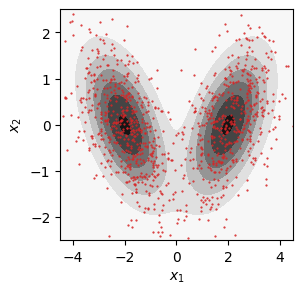

In [3]:
import matplotlib.pyplot as plt

x = np.linspace(-5, 5, 1_000)
y = np.linspace(-5, 5, 1_000)
X, Y = np.meshgrid(x, y)
P = pdf_bivariate_gaussian(X, Y, params=dist_params)

fig, ax = plt.subplots(figsize=(3, 3))
ax.contourf(X, Y, P, cmap="Greys")
ax.scatter(samples[:, 0], samples[:, 1], c="tab:red", s=0.3)
ax.set_xlabel("$x_1$")
ax.set_xlim([-4.5, 4.5])
ax.set_ylabel("$x_2$")
ax.set_ylim([-2.5, 2.5])
plt.show()

Looks good! The underlying distribution is colored in black and white and our samples, in red, look clustered around the darker regions which represents higher density. Now we'll test the density estimation methods.

Before continuing, here we'll define a function to ease plotting later in this Notebook. The cell for this function is collapsed by default but can be expanded for viewing.

In [4]:
import matplotlib.ticker as tkr

def plot_density_comparison(X, Y, P, fx):
    fig, ax = plt.subplots(figsize=(6, 4))
    cs1 = ax.contourf(X, Y, P, cmap="Greys")
    cs2 = ax.contourf(X, Y, fx.reshape(X.shape), cmap="Reds", alpha=0.50)
    # Details
    ax.set_xlabel("$x_1$")
    ax.set_xlim([-4.5, 4.5])
    ax.set_ylabel("$x_2$")
    ax.set_ylim([-2.5, 2.5])
    ax.grid(ls="--", alpha=0.50)
    # Colorbars
    cbar1 = fig.colorbar(cs1)
    cbar1.ax.yaxis.set_major_formatter(tkr.FormatStrFormatter('%.2f'))
    cbar1.set_label('True', labelpad=-34, y=1.07, rotation=0)
    cbar2 = fig.colorbar(cs2)
    cbar2.ax.yaxis.set_major_formatter(tkr.FormatStrFormatter('%.3f'))
    cbar2.set_label('Est.', labelpad=-32, y=1.07, rotation=0)
    return fig, ax

## Density Estimation
### Binning
For histogram based density estimation or "binning" there are several "rules-of-thumb" for selecting an adequate number of bins. The problem is that all of these rules have been developed for one-dimensional data and there are no similar rules for the higher-dimensional cases. As such, binning strategies are highly dependant on a specific user or application.

As guidance, the **UNITE** toolbox includes a function that esitmates the "ideal" number of bins across all dimensions of a dataset using some of the well established rules-of-thumb. The result is given in a dictionary that can be indexed by the name of a speicific rule to get a list of the number of bins required per dimension.

In [5]:
from unite_toolbox.bin_estimators import estimate_ideal_bins

n_bins = estimate_ideal_bins(samples, counts=True)
print("Rule --> Bins")
for key, val in n_bins.items():
    print(f"{key:<8} {val}")

Rule --> Bins
fd       [14, 26]
scott    [14, 20]
sturges  [12, 12]
doane    [13, 13]


In this case, as the Sturge's rule-of-thumb gives our the least amount of bins, we'll choose this one as we'll be using it for plotting later. This might not be optimal in terms of how close the density calculated at each bin is to the "true" density but that is not of interest for this example. We just want to see the differences between methods. The selection of a specific binning scheme is highly dependant on a given application. 

In [6]:
n_bins = estimate_ideal_bins(samples, counts=False)["sturges"]
# counts=False to use the binning scheme later as ticks in a plot
# of the results

Now let's see how "binning" evaluates density! To make this exercise more visual, we'll evaluate a grid of points and plot the estimated densities on top of the true density plot of the bivariate Gaussian distribution. To evaluate density, we just need one function from the **UNITE** toolbox.

In [7]:
from unite_toolbox.bin_estimators import calc_bin_density

pos = np.column_stack((X.flatten(), Y.flatten())) # stack the X and Y vectors used for plotting
fx2 = calc_bin_density(x=pos, data=samples, edges=n_bins)

And now we plot using the previously defined function. In addition, we'll use the previously calculated "sturges" binning scheme as tick marks in our plot to distinguish between different bins.

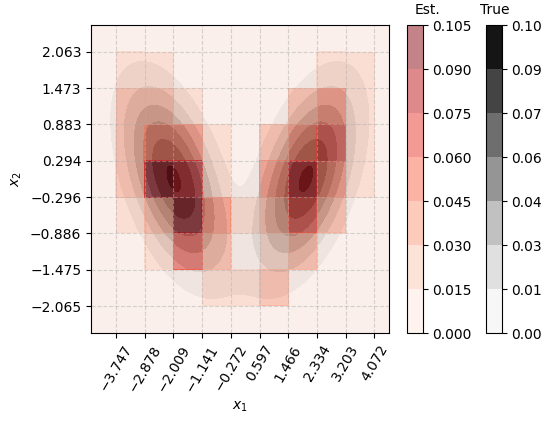

In [8]:
# Plot
fig, ax = plot_density_comparison(X, Y, P, fx2) # Previously defined funtion
# Some additional details
ax.set_xticks(n_bins[0])
ax.xaxis.set_tick_params(rotation=60)
ax.set_xlim([-4.5, 4.5])
ax.set_yticks(n_bins[1])
ax.set_ylim([-2.5, 2.5])
plt.show()

Nice! Generally we see the typical grid of a 2D histogram and, based on the estimated densities, we can say that binning using "sturges" rule-of-thumb tends to overestimate density.

### KDE

Now for KDE the **UNITE** toolbox uses a Gaussian kernel. Therefore there are not as many options to be tweaked.

In [9]:
from unite_toolbox.kde_estimators import calc_kde_density
fx3 = calc_kde_density(x=pos, data=samples)

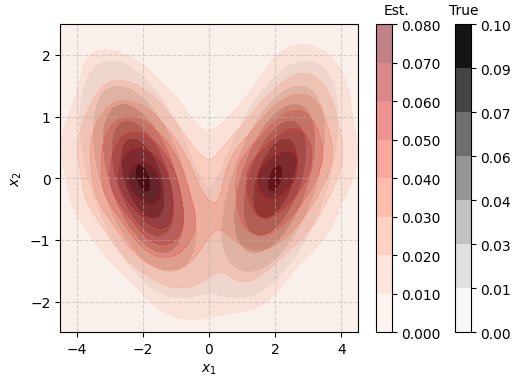

In [10]:
fig, ax = plot_density_comparison(X, Y, P, fx3) # Previously defined funtion
plt.show()

KDE-based estimation is generally very good at matching this case because of the use of a Gaussian kernel. This might not be the case for other types of data.

### $k$-NN

Finally we have $k$NN-based estimation which, again, requires very little tweaking. One thing to note though is the number of neighbors $k$ being used for estimation. $k=50$ is much higher than any of the recommended values for estimating information-theoretic quantities where $k$ ranges between $k=1$ and $k=15$. If a lower value of $k$ is used, a lower radius gives less influence to each individual sample and its neighbors.

In [11]:
from unite_toolbox.knn_estimators import calc_knn_density
fx4 = calc_knn_density(x=pos, data=samples, k=50)

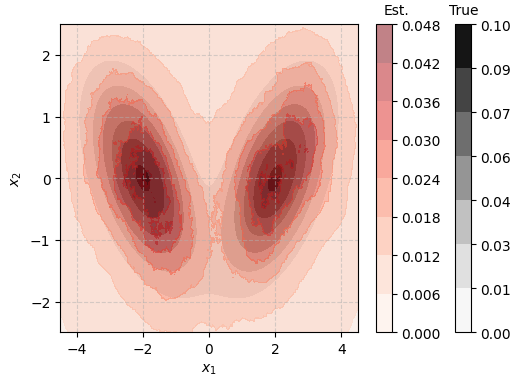

In [12]:
fig, ax = plot_density_comparison(X, Y, P, fx4) # Previously defined funtion
plt.show()

Another thing to note is the difference in estimated densities for $k$-NN and the true distribution, and the other methods tried previously. The variance of $k$-NN based estimation for density is very high and therefore it's not recommended for density estimation using only one sample. The process does benefit from multiple samples from which the average density can be calculated.

### Comparing Methods

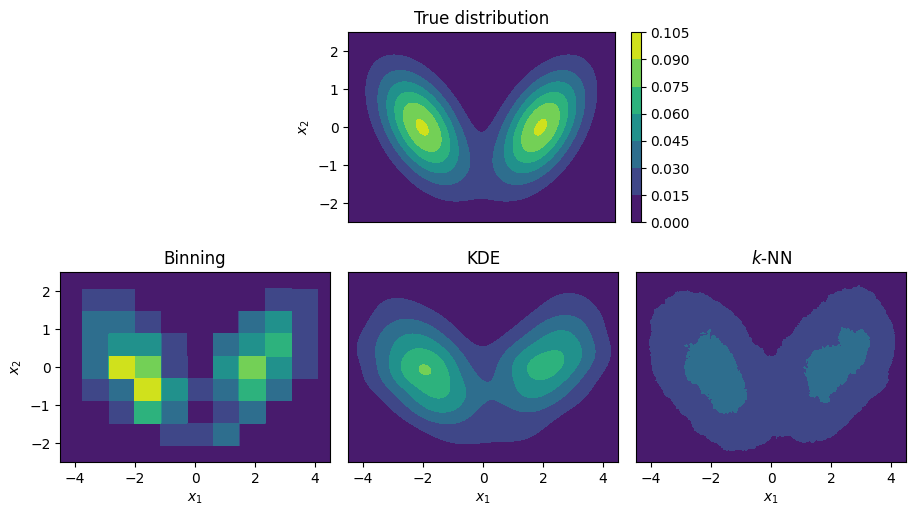

In [13]:
fig = plt.figure(figsize=(9, 5))
b = 0.30
h = 0.38

ax1 = fig.add_axes((0.38, 0.57, b + 0.07, h))
ax2 = fig.add_axes((0.06, 0.09, b, h))
ax3 = fig.add_axes((0.38, 0.09, b, h))
ax4 = fig.add_axes((0.70, 0.09, b, h))

cbar = ax1.contourf(X, Y, P)



ax2.contourf(X, Y, fx2.reshape(X.shape), levels=cbar.levels)
ax3.contourf(X, Y, fx3.reshape(X.shape), levels=cbar.levels)
ax4.contourf(X, Y, fx4.reshape(X.shape), levels=cbar.levels)

for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xlim([-4.5, 4.5])
    ax.set_ylim([-2.5, 2.5])

for ax in [ax1, ax2]:
    ax.set_ylabel("$x_2$")

for ax in [ax2, ax3, ax4]:
    ax.set_xlabel("$x_1$")

for ax in [ax3, ax4]:
    ax.get_yaxis().set_visible(False)

ax1.get_xaxis().set_visible(False)

ax2.set_title("Binning")
ax3.set_title("KDE")
ax4.set_title("$k$-NN")
ax1.set_title("True distribution")
plt.colorbar(cbar)
plt.show()

Finally, the previous plot shows the three density estimation methods shown in this Tutorial on the same color scale as the true distribution. From this plot alone, the differences between methods become apparent. KDE appears as the most suitable method for density estimation while $k$-NN is not recommended at all.